In [1]:
import pandas as pd
import numpy as np

# plots
import matplotlib.pyplot as plt
import seaborn as sns
from aquarel import load_theme
theme = load_theme("arctic_light")
theme.apply()

In [2]:
try:
    sunspots = pd.read_csv("data/Sunspots.csv", index_col="Date", usecols = ["Date", "Monthly Mean Total Sunspot Number"])
    sunspots.index = pd.to_datetime(sunspots.index)
    sunspots.index.freq = "M"
except:
    print("Error while loading the file.")

In [3]:
# Checking length and missing values
print(f"Shape : {sunspots.shape}")
print(f"Missing values : {sunspots.isna().sum().sum()}")

Shape : (3265, 1)
Missing values : 0


In [4]:
name = sunspots.columns[0] # Will simplify the futur calls

In [5]:
seasonal_period = 11 * 12 # The seasonal period is 11 years, so 11 * 12 (months) points
# https://en.wikipedia.org/wiki/Solar_cycle

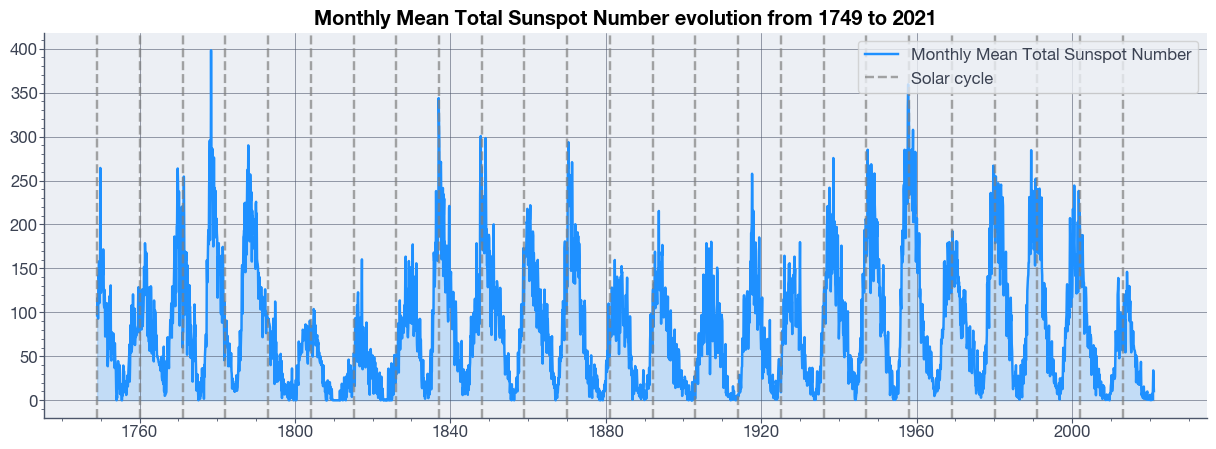

In [6]:
plt.figure(figsize = (15, 5))

plt.plot(sunspots.index, sunspots.loc[:, name], color = "dodgerblue", label = name)

plt.fill_between(x = sunspots.index,
                 y1 = sunspots.loc[:, name],
                 y2 = [0] * sunspots.shape[0],
                 alpha = .2,
                 color = "dodgerblue")

for seasonal_idx in np.arange(0, sunspots.shape[0], step=seasonal_period):
    if seasonal_idx == 0:
        plt.axvline(sunspots.index[seasonal_idx], color = "grey", linestyle = "dashed", alpha = .7, label = "Solar cycle")
    else:
        plt.axvline(sunspots.index[seasonal_idx], color = "grey", linestyle = "dashed", alpha = .7)
plt.title(f"{name} evolution from {np.min(sunspots.index.year)} to {np.max(sunspots.index.year)}", 
          color = "black", 
          fontweight = "bold")
plt.legend(loc = "upper right")
plt.show()

In [7]:
# Splitting in a simple train/test evaluation (no CV)
# test set is the last 20% of the dataset
break_point = seasonal_period
train = sunspots.iloc[:-break_point]; test = sunspots.iloc[-break_point:]

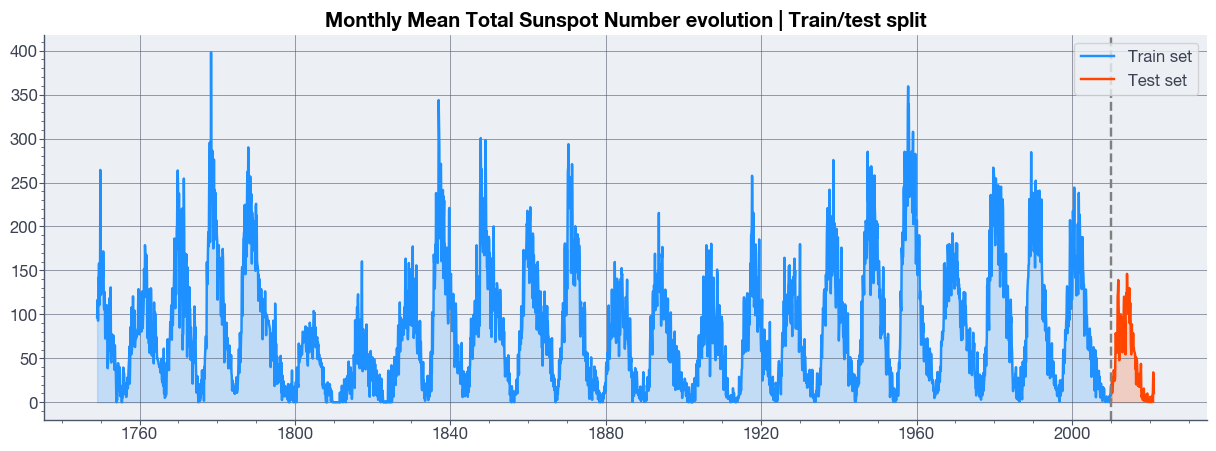

In [8]:
plt.figure(figsize = (15, 5))

plt.plot(train.index, train.loc[:, name], color = "dodgerblue", label = "Train set")

plt.fill_between(x = train.index,
                 y1 = train.loc[:, name],
                 y2 = [0] * train.shape[0],
                 alpha = .2,
                 color = "dodgerblue")

plt.plot(test.index, test.loc[:, name], color = "orangered", label = "Test set")
plt.fill_between(x = test.index,
                 y1 = test.loc[:, name],
                 y2 = [0] * test.shape[0],
                 alpha = .2,
                 color = "orangered")

plt.axvline(sunspots.index[-break_point], color = "grey", linestyle = "dashed")

plt.title(f"{name} evolution | Train/test split", color = "black", fontweight = "bold")
plt.legend(loc = "upper right")
plt.savefig("plots/train_test_split.svg", bbox_inches = 'tight')

In [9]:
def nixtla_preprocess_column(serie: pd.DataFrame) -> pd.DataFrame:
    """Convertis un pandas DataFrame en un DataFrame interpretable par les modèles Nixtla.

    Args:
        serie (pd.DataFrame): Le vecteur à convertir.

    Returns:
        pd.DataFrame: Le dataframe formatté.
    """
    returned_dataset = pd.DataFrame()
    returned_dataset["unique_id"] = [serie.columns[0]] * len(serie)
    returned_dataset["ds"] = serie.index
    returned_dataset["y"] = serie.values
    return returned_dataset

In [10]:
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor

fcst = MLForecast(
    models=[LinearRegression(),
            LGBMRegressor(n_estimators = 500),
            SVR(kernel = "rbf"),
            KNeighborsRegressor(n_neighbors = 10)],
    freq="M",
    lags=[1, 2, 3, 4, 5],
    target_transforms=[Differences([seasonal_period])]
)

In [11]:
fitted = fcst.fit(nixtla_preprocess_column(train))

forecasts = fitted.predict(test.shape[0])
forecasts.set_index("ds", inplace = True)
forecasts.drop("unique_id", axis = 1, inplace = True)
forecasts = np.maximum(0, forecasts) # apply ReLU

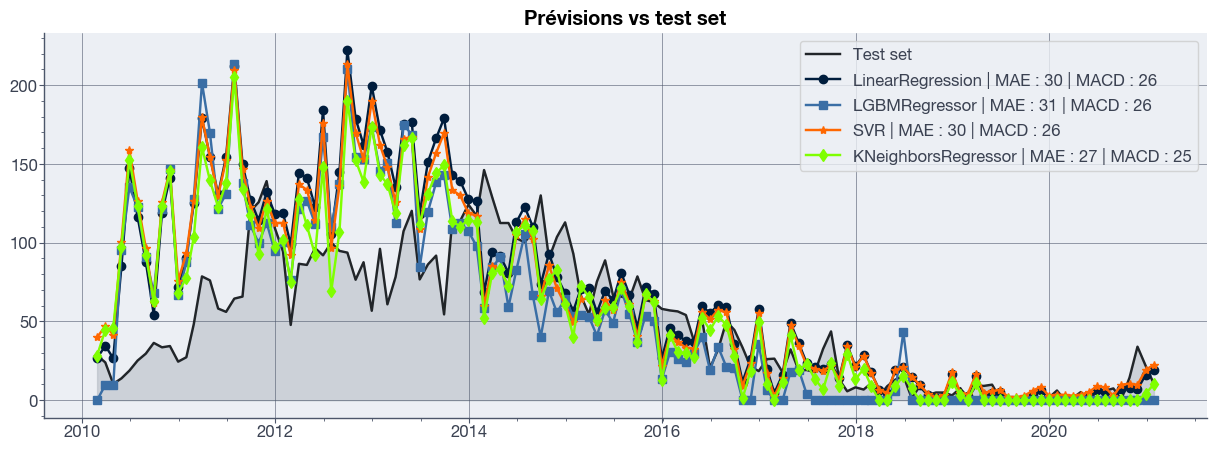

In [12]:
from sacd_tools import mean_absolute_coef_differences, plot_joint_errors, plot_multiple_joint_errors, plot_joint_betas
from sklearn.metrics import mean_absolute_error

plt.figure(figsize = (15, 5))

plt.plot(test.index, test.loc[:, name], color = "#212529", label = "Test set")
plt.fill_between(x = test.index,
                 y1 = test.loc[:, name],
                 y2 = [0] * test.shape[0],
                 alpha = .5,
                 color = "#adb5bd")

for (model, color, point) in zip(forecasts.columns, ["#001d3d", "#3a6ea5", "#ff6700", "#7FFF00"], ["o", "s", "*", "d"]):
    plt.plot(test.index, forecasts.loc[:, model], label = model+str(f" | MAE : {mean_absolute_error(test.values.ravel(), forecasts.loc[:, model]):.0f}")+str(f" | MACD : {mean_absolute_coef_differences(test.values.ravel(), forecasts.loc[:, model]):.0f}"), marker = point, color = color)
plt.title("Prévisions vs test set", fontweight = "bold", color = "black")
plt.legend(loc = "upper right")
plt.savefig("plots/forecasts.svg", bbox_inches = 'tight')

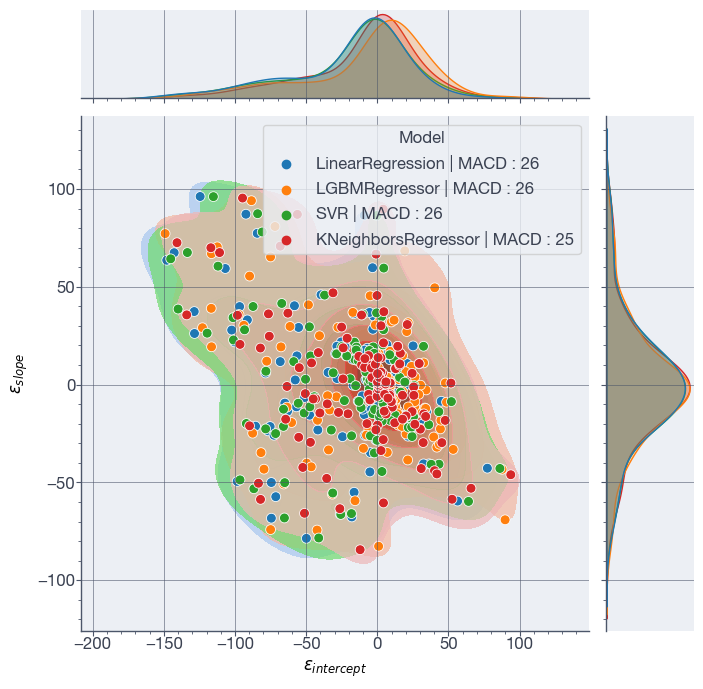

In [13]:
plot_multiple_joint_errors(test.values.ravel(), forecasts)
plt.savefig("plots/multiple_joints.svg", bbox_inches = 'tight')

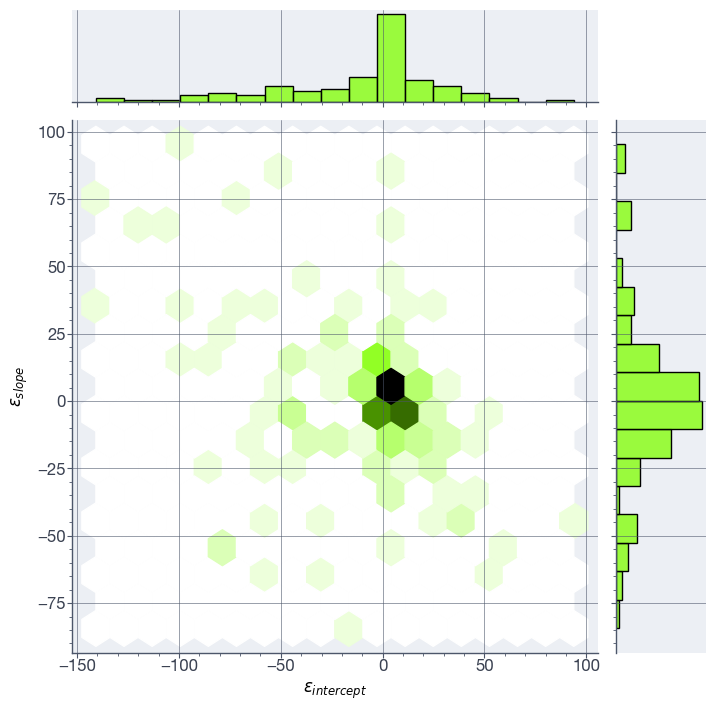

In [14]:
plot_joint_errors(test.values.ravel(), forecasts.loc[:, model], color = "#7FFF00")
plt.savefig("plots/errors.svg", bbox_inches = 'tight')

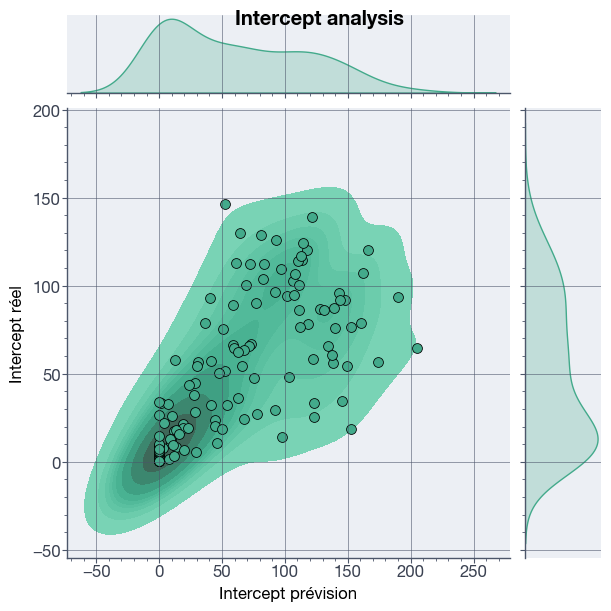

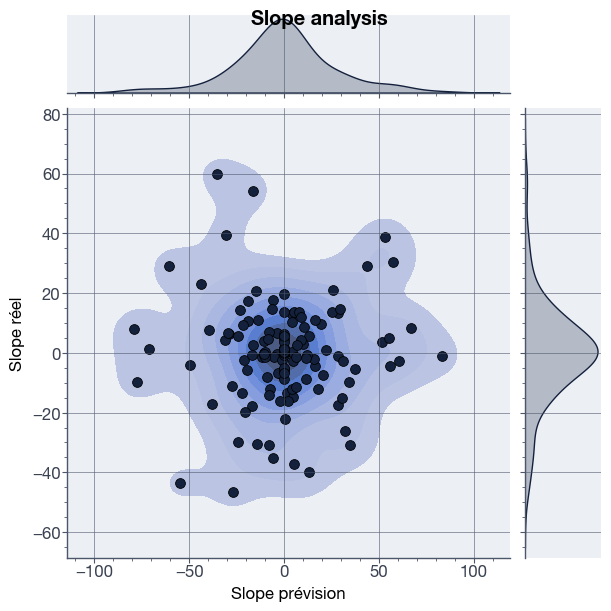

In [15]:
plot_joint_betas(test.values.ravel(), forecasts.loc[:, model])
plt.savefig("plots/intercepts.svg", bbox_inches = 'tight')

plot_joint_betas(test.values.ravel(), forecasts.loc[:, model], type_coef = "slope")
plt.savefig("plots/slope.svg", bbox_inches = 'tight')